In [3]:
from fastai2.text.all import *

## Create databunch form LM

In [2]:
BPTT=10
BS=64

EN_FILE = Path('data/en-clean.txt')
EN_TEXT = EN_FILE.read()[1:].replace('\n', '').replace('  ', ' ')

In [3]:
toks = tokenize1(EN_TEXT)

In [4]:
toks[:10]

(#10) ['xxbos','the','project','gutenberg','ebook','of','peter','pan',',','by']

In [5]:
vocab = make_vocab(Counter(toks), min_freq=3, max_vocab=2000)

len(vocab)

2008

In [6]:
vocab[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 '.',
 'the',
 'and',
 'to',
 'a']

In [7]:
# arbitrary way of splitting text into 'examples', would probably be better to split by chapters
# or something along these lines but shouldn't make much of a difference
txts = np.array_split(EN_TEXT.split(), 100)

In [9]:
RandomSplitter(seed=42)

<function fastai2.data.transforms.RandomSplitter.<locals>._inner(o, **kwargs)>

In [1]:
dblock = DataBlock(blocks=(TextBlock(vocab, is_lm=True)), splitter=RandomSplitter(seed=42))

NameError: name 'DataBlock' is not defined

In [9]:
dbunch_lm = dblock.databunch(txts, seq_len=BPTT, bs=BS) 

In [10]:
dbunch_lm.one_batch()[0].shape

torch.Size([64, 10])

In [11]:
# % of unknown tokens
torch.mean((torch.cat([tup[0] for tup in dbunch_lm.valid_ds]) == 0).float())

tensor(0.1104)

## Train LM

In [12]:
# def loss():
#     preds = []
#     targs = []

#     learn.model.eval()
#     with torch.no_grad():
#         for b in learn.dbunch.valid_dl:
#             preds.append(learn.model(b[0])[0])
#             targs.append(b[1])

#     preds = torch.cat(preds, 1)
#     targs = torch.cat(targs, 1)
    
#     return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [105]:
class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) ) # these are embeddings!
        
        self.p_matrix_as_embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.p_matrix_as_embeddings.weight = nn.Parameter(torch.eye(self.num_embeddings) * 45 - 0.0075)
        self.p_matrix_as_embeddings.weight.requires_grad = False
        
    def forward(self, words):
        return self.p_matrix_as_embeddings(words).softmax(-1) @ self.weight
    
    def reset_parameters(self): pass

In [106]:
class pAWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False, packed=False):
        store_attr(self, 'emb_sz,n_hid,n_layers,pad_token,packed')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
#         self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder = PermuteEmbedding(vocab_sz, emb_sz, padding_idx=pad_token)
#         self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        self.encoder_dp = self.encoder # chosing to train without embedding dropout (to reduce code complexity + not sure it makes a lot of sense for what we want to do anyhow) 
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

In [107]:
import fastai2
fastai2.text.models.core._model_meta[pAWD_LSTM] = fastai2.text.models.core._model_meta[AWD_LSTM]

In [108]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

In [90]:
learn.model[0].encoder.p_matrix_as_embeddings.weight.mean()

tensor(0.0149, device='cuda:0')

In [91]:
learn.model[0].encoder.p_matrix_as_embeddings.weight.std()

tensor(1.0040, device='cuda:0')

In [92]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.488640,5.201694,0.120681,181.579666,00:10
1,5.054406,4.812228,0.168793,123.005333,00:11
2,4.773728,4.559972,0.202604,95.580833,00:11
3,4.616649,4.408270,0.219661,82.127251,00:11
4,4.479479,4.306356,0.231076,74.169716,00:11
5,4.362522,4.225396,0.239844,68.401566,00:11
6,4.275565,4.157415,0.242904,63.906136,00:11
7,4.198876,4.108688,0.249870,60.866829,00:11
8,4.117675,4.075346,0.251085,58.870846,00:11
9,4.006471,4.048649,0.255512,57.319958,00:11


In [93]:
# learn.save('pLSTM_mixer_softmax_10epochs')

In [109]:
learn.load('pLSTM_mixer_softmax_10epochs')

In [113]:
learn.predict('peter was', n_words=3, temperature=0.5)

'peter was a private man'

In [114]:
import warnings

@patch_to(LMLearner)
def optimize_permutation(self):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        self.freeze_to(4)
    learn.model[0].encoder.p_matrix_as_embeddings.weight.requires_grad = True
    
@patch_to(LMLearner)
def optimize_model(self):
    self.unfreeze()
    learn.model[0].encoder.p_matrix_as_embeddings.weight.requires_grad = False

In [115]:
learn.optimize_permutation()

In [101]:
# def aza_loss(input=None, target=None, scaling_factor=5/2000, debug=False):
#     p = learn.model[0].encoder.p_matrix_as_embeddings.weight
#     sums_to_one = (1-p.abs().sum(dim=0)).abs().sum() + (1-p.abs().sum(dim=1)).abs().sum()
# #     extremize = (1-p.max(dim=0)[0]).abs().sum() + (1-p.max(dim=1)[0]).abs().sum() # + (p.min(dim=0)[0]).abs().max()#(10*(1-p.max()).abs()) + (10*p.min()).abs()
#     the_model = CrossEntropyLossFlat()(input, target)
#     if debug: return sums_to_one, the_model
#     else:     return scaling_factor * sums_to_one + (1 - scaling_factor) * the_model

In [102]:
# learn.loss_func = aza_loss

In [116]:
preds, targs = learn.get_preds()

In [120]:
def loss():
    preds = []
    targs = []

    learn.model.eval()
    with torch.no_grad():
        for b in learn.dbunch.valid_dl:
            preds.append(learn.model(b[0])[0])
            targs.append(b[1])

    preds = torch.cat(preds, 1)
    targs = torch.cat(targs, 1)
    
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [134]:
loss()

(4.348971843719482, 0.20972369611263275)

In [140]:
nn.init.kaiming_normal_(learn.model[0].encoder.p_matrix_as_embeddings.weight)

Parameter containing:
tensor([[ 0.0266,  0.0554,  0.0319,  ..., -0.0115, -0.0229, -0.0303],
        [ 0.0244, -0.0182,  0.0214,  ..., -0.0108,  0.0201, -0.0299],
        [-0.0618,  0.0857,  0.0072,  ..., -0.0383,  0.0101,  0.0591],
        ...,
        [ 0.0042,  0.0109,  0.0350,  ...,  0.0244,  0.0249, -0.0039],
        [-0.0229,  0.0267,  0.0325,  ...,  0.0184,  0.0076,  0.0124],
        [-0.0472,  0.0060, -0.0279,  ..., -0.0122, -0.0135, -0.0665]],
       device='cuda:0', requires_grad=True)

In [136]:
loss()

(6.752859115600586, 0.04380737990140915)

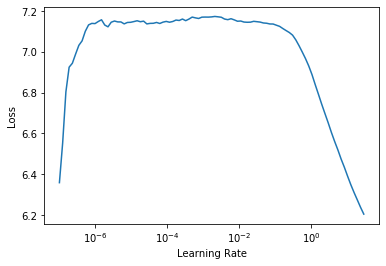

In [137]:
learn.lr_find(end_lr=100)

In [141]:
learn.fit(5, 1e-1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.200071,4.217505,0.230859,67.863922,00:09
1,4.034425,4.125762,0.242665,61.915001,00:09
2,4.009288,4.100305,0.245573,60.358700,00:09
3,3.975339,4.087408,0.248611,59.585251,00:09
4,3.933480,4.077248,0.250304,58.982929,00:09


In [142]:
learn.save('pLSTM_mixer_softmax_15epochs_permute_embeddings')

In [143]:
def hitInTopN(n=1, how_many=None, prints=True):
    data = learn.model[0].encoder.p_matrix_as_embeddings.weight.argsort(descending=True)[10:10+how_many, :n]
    hits = torch.any(data == torch.arange(10, how_many+10).reshape(-1,1).cuda(), -1)
    return hits.float().mean().item()

In [144]:
hitInTopN(1, 100), hitInTopN(5, 100)

(0.8700000047683716, 0.8700000047683716)

In [145]:
acc1 = [(x, hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, hitInTopN(10, x)) for x in range(50,1500,200)]

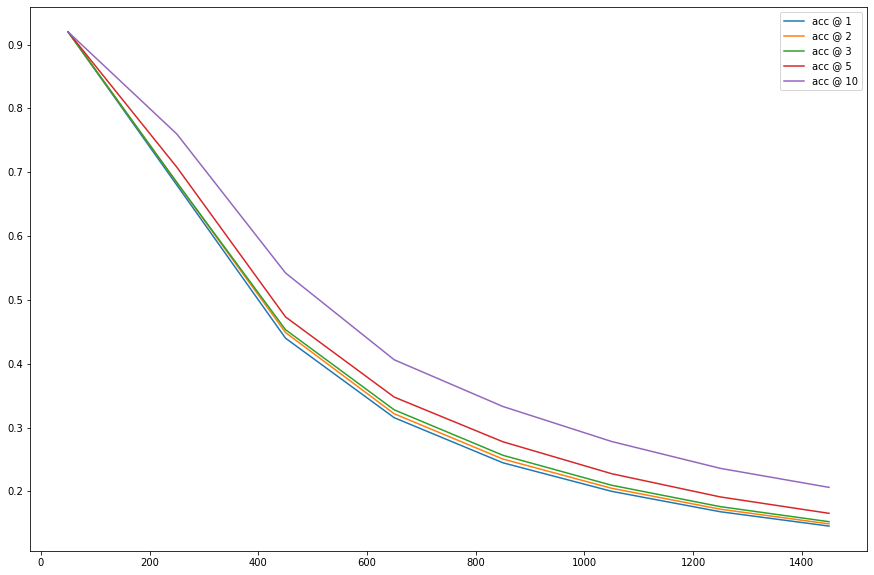

In [146]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [147]:
data = learn.model[0].encoder.p_matrix_as_embeddings.weight.argsort(descending=True)[:, :5]
print('actual word\t\tpredictions\n')
for i in range(60, 80):
    print(f'{learn.dbunch.vocab[i]}\t\t{[learn.dbunch.vocab[idx] for idx in data[i]]}')

actual word		predictions

would		['would', 'i', 'who', 'we', 'which']
then		['presently', 'he', "'", 'and', '“']
we		['we', 'chapter', 'whose', 'he', 'she']
my		['my', '“', 'your', '-', 'no']
what		['what', 'i', 'you', 'who', 'she']
up		['up', 'down', ',', 'by', 'into']
from		['from', '.', 'into', 'of', ':']
which		['which', 'we', 'they', 'i', 'chapter']
out		['out', 'down', ',', 'away', 'back']
me		['me', '.', 'you', '_', '--']
one		['one', 'hook', 'tom', 'it', 'peter']
if		['if', 'would', 'could', '”', ':']
now		['so', 'then', 'said', 'there', 'oh']
when		['because', 'which', 'till', ':', 'what']
them		['them', 'him', '.', 'there', 'that']
or		['or', 'chapter', 'the', 'an', '-']
could		['could', '"', "'", '”', 'will']
been		['been', "'re", 'have', 'were', 'to']
are		['is', 'were', "'s", 'will', "'re"]
an		['an', 'chapter', '-', 'a', '[']
